C:\Users\Hatim\AppData\Local\Temp\ipykernel_15000\2564890239.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Hatim\AppData\Local\Temp\ipykernel_15000\2564890239.py:61: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('enron_05_17_2015_with_labels_v2.csv\enron_05_17_2015_with_labels_v2.csv')


   Unnamed: 0                                     Message-ID  \
0           0  <18782981.1075855378110.JavaMail.evans@thyme>   
1           1  <15464986.1075855378456.JavaMail.evans@thyme>   
2           2  <24216240.1075855687451.JavaMail.evans@thyme>   
3           3  <13505866.1075863688222.JavaMail.evans@thyme>   
4           4  <30922949.1075863688243.JavaMail.evans@thyme>   

                  Date                                    From  \
0  2001-05-14 23:39:00  frozenset({'phillip.allen@enron.com'})   
1  2001-05-04 20:51:00  frozenset({'phillip.allen@enron.com'})   
2  2000-10-18 10:00:00  frozenset({'phillip.allen@enron.com'})   
3  2000-10-23 13:13:00  frozenset({'phillip.allen@enron.com'})   
4  2000-08-31 12:07:00  frozenset({'phillip.allen@enron.com'})   

                                       To    Subject           X-From  \
0     frozenset({'tim.belden@enron.com'})        NaN  Phillip K Allen   
1  frozenset({'john.lavorato@enron.com'})        Re:  Phillip K Allen   

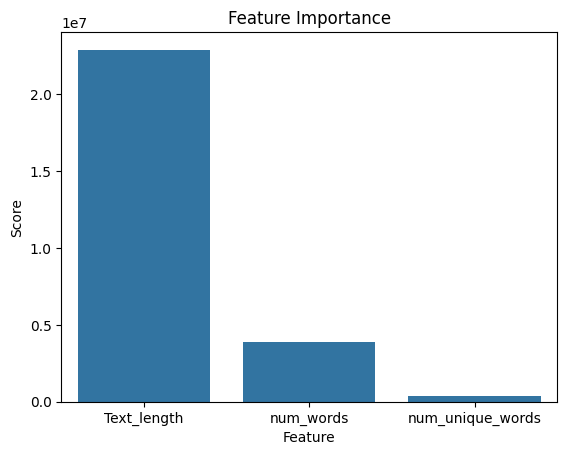

c:\Users\Hatim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


ValueError: X has 100 features, but SelectKBest is expecting 3 features as input.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split


# Function to clean text
def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

# Function to predict spam/ham category
def predict_spam_ham(text, model, tokenizer, max_len, label_encoder):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)
    return label_encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

# Function to plot training metrics
def plot_training_metrics(history, img_prefix='training'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure()
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{img_prefix}_accuracy.png')  # Save as image
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{img_prefix}_loss.png')  # Save as image
    plt.show()

# Load the dataset
df = pd.read_csv('enron_05_17_2015_with_labels_v2.csv\enron_05_17_2015_with_labels_v2.csv')

# Display initial data information
print(df.head())

# Combine and clean text data
df['Text'] = df['Subject'].fillna('') + ' ' + df['content'].fillna('')
df['Text'] = df['Text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['labeled'])

# Tokenization and Padding
MAX_WORDS = 10000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = df['Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering: Example of adding additional features
df['Text_length'] = df['Text'].apply(len)
df['num_words'] = df['Text'].apply(lambda x: len(x.split()))
df['num_unique_words'] = df['Text'].apply(lambda x: len(set(x.split())))

# Feature Selection: SelectKBest with chi-squared
# Assuming df['Text'] is already cleaned and df['Label'] is your target variable
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Text'])

# Additional features (make sure these columns exist or are created beforehand)
additional_features = df[['text_length', 'subject_length', 'count_exclamation', 'count_links']]
X = np.hstack((X_tfidf.toarray(), additional_features))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Label'], test_size=0.2, random_state=42)

# Feature selection
selector = SelectKBest(chi2, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Visualize selected features importance
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Score': selector.scores_
})
sns.barplot(x='Feature', y='Score', data=feature_scores)
plt.title('Feature Importance')
plt.show()

# Incorporate additional features into training and testing sets
X_train_additional = selector.transform(X_train)
X_test_additional = selector.transform(X_test)

# Combine text features with additional features
X_train_combined = np.hstack((X_train, X_train_additional))
X_test_combined = np.hstack((X_test, X_test_additional))

# Building the model
model = Sequential()
model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_combined, y_train, epochs=5, batch_size=32, validation_data=(X_test_combined, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_combined, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Example prediction
example_text = "Win a brand new car! Click here for details."
prediction = predict_spam_ham(example_text, model, tokenizer, MAX_LEN, label_encoder)
print(f"Prediction: {prediction}")

# Plot the training and validation metrics
plot_training_metrics(history, img_prefix='enron_spam_detection')
